# GenerateFramesFiles.ipynb

### Notebook for generating frames files for LIGO data analysis from SXS format .h5 waveform files

Maria Okounkova (m.okounkova@gmail.com)

### Imports and setup

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import h5py
from astropy import constants as const
from scipy.interpolate import InterpolatedUnivariateSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import os
from shutil import copyfile
import fileinput
import seaborn as sns
import math
from math import pi
import pycbc
from pycbc.filter.matchedfilter import overlap
import json
from ipynb.fs.full.Auxiliary import ReadExtrapolatedModes, SubtractPeakTime, dt_eval, df_eval, \
                                    PadAndProject, EllinKm, ComputeSNR, ComputeMultiDetectorSNR, TargetSNR

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['legend.fontsize'] = 24
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 1


### Set your root directory (where the BeyondGRAnalysis repository lives)

In [6]:
root_dir = '/home/maria.okounkova/BeyondGRAnalysis/'

### Helper functions for creating and reading injected parameter dictionaries

In [7]:
def FullParamsDictionary(params_dict):
    """ Given a total mass, q > 1, and spins a_1, a_2, in params_dict, 
        compute m_1, m_2, m_chirp, and chi_eff and add to params_dict
         """
    mass = params_dict['mass']
    q = params_dict['q']
    a_1 = params_dict['a_1']
    a_2 = params_dict['a_2']
    
    m_2 = mass / (1 + q)
    m_1 = q*m_2
    m_chirp = (q/(1+q)**2)**(3/5)*mass
    
    params_dict['m_1'] = m_1
    params_dict['m_2'] = m_2
    params_dict['mass_ratio'] = 1.0/q
    params_dict['chirp_mass'] = m_chirp
    
    ## Assuming aligned spin for now 
    chi_eff = (a_1[2]/m_1 + a_2[2]/m_2)/mass
    params_dict['chi_eff'] = chi_eff
    
    return params_dict

def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Methods to create the frames files - evaluate the waveforms, project the data, and write frames files

In [8]:
def GenerateFramesHelper(name, timeH, strainH, timeL, strainL, timeV, strainV, params_dict):
    """ Generate frames files given hanford and livingston data.
        rh_dir is the directory base directory for the data 
        Also make bayeswave files if necessary """

    frames_dir = 'BilbyBayeswaveAnalysis/' + name + '/Frames/'
    bilby_dir = 'BilbyBayeswaveAnalysis/' + name + '/'
    
    os.makedirs(frames_dir)
    
    dt = dt_eval(timeH)

    H1 = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1 = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
    V1 = TimeSeries(strainV,sample_rate=1/dt,epoch=timeL[0],channel="V1:LDAS_STRAIN")

    H1.write(frames_dir + "H1.gwf")
    L1.write(frames_dir + "L1.gwf")
    V1.write(frames_dir + "V1.gwf")
    
    ## Copy over the bilby files and replace path variables
    for file in ['aLIGOZeroDetHighPower-PSD_25Hz.txt', 'Frame.prior', 'Frames.py', 
                 'run_bilby.dag', 'run_bilby.sh', 'run_bilby.sub']:
        
        ## Copy over base file
        copyfile('BilbyBayeswaveAnalysis/Files/' + file, bilby_dir + file)
        
        ## Replace path variables
        with fileinput.FileInput(bilby_dir + file, inplace=True) as f:
            for line in f:
                print(line.replace('FRAMES_DIR', name), end='')
            
    ## Logs directory for Bilby
    os.mkdir(bilby_dir + 'Logs')
    
    ## Bayeswave files
    bw_dir = bilby_dir + 'BayesWave'
    os.mkdir(bw_dir)
    
    # Make the bayeswave cache files
    start_dir = root_dir
    with open(bw_dir + '/H1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'H1.gwf' + '\n')
    with open(bw_dir + '/L1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'L1.gwf' + '\n')
    with open(bw_dir + '/V1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'V1.gwf' + '\n')

    # Copy over the bayewave ini files
    copyfile('run_bw.sh', bw_dir + '/run_bw.sh')
    copyfile('dCS.ini', bw_dir + '/dCS.ini')
    
    # Change the path to the cache files in the copied dCS.ini file
    with fileinput.FileInput(bw_dir + '/dCS.ini', inplace=True) as file:
        for line in file:
            print(line.replace('CACHE_DIR', bw_dir), end='')
            
def CreateFramesFiles(p_in, p_out, params_dict, desired_snr, ell = "0p0"):
    
    """
    Given a directory p_out in which the numerical relativity waveform lives (in an SXS format), 
    apply the astrophysical parameters given in params_dict to the waveform, and write frames
    to directory p_out. 
    
    desired_snr corresponds to the SNR we would like for the frames files, which is 
    achieved by adjusting the distance. 
    """
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p_in, params_dict, interpolate = False)
    timeH, strainH, timeL, strainL, timeV, strainV = PadAndProject(time, h_plus, h_cross, params_dict, verbose = True)
    
    ## Update distance for target SNR
    strainH, strainL, strainV, params_dict = TargetSNR(timeH, strainH, timeL, strainL, timeV, strainV, params_dict, desired_snr)
    GenerateFramesHelper(p_out, timeH, strainH, timeL, strainL, timeV, strainV, params_dict)
    
    ## Compute SNRs
    SNR_H = ComputeSNR(timeH, strainH)
    SNR_L = ComputeSNR(timeL, strainL)
    SNR_V = ComputeSNR(timeV, strainV)
    SNR = ComputeMultiDetectorSNR(timeH, strainH, timeL, strainL, timeV, strainV)
    print("Network SNR: ", SNR)
    
    ## Print out the parameter values
    params_dict = FullParamsDictionary(params_dict)
    params_dict['source'] = p_in
    params_dict['H_SNR'] = SNR_H
    params_dict['L_SNR'] = SNR_L
    params_dict['V_SNR'] = SNR_V
    params_dict['SNR'] = SNR
    params_dict['ell'] = ell 
    params_dict['ell_km'] = EllinKm(ell, params_dict['mass'])
    with open('BilbyBayeswaveAnalysis/' + p_out + '/parameters.json', 'w') as fp:
        json.dump(params_dict, fp)
    fp.close()

### Actually generate frames files

In [9]:
## Desired injection parameters
My_Params_Dict = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 400.0, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               'a_1' : [0, 0, 0.329892752405], 'a_2' : [0, 0, -0.439940981499], \
               'f_low' : 0, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821}
 

## Desired injection SNR (note that this will change dist_mpc)
SNR = 100
## Desired value for the coupling constant
ell = '0p4'

## Generate the frames files - note that the file 'Waveforms/Lev5/dCS_Strain_' + ell + '.h5' needs to exist, 
## which you can create with Generate_dCS_Strain.py
CreateFramesFiles('Waveforms/Lev5/dCS_Strain_' + ell + '.h5', 'dCS_' + ell + '_' + str(SNR), My_Params_Dict, SNR, ell=ell)

t0 parameter:  1126259462.0


Time delay between detectors -0.006985699700979881 -0.004281157268499984
geocenter time delay H:  0.014694082894586626
geocenter time delay L:  0.007708383193606742
geocenter time delay V:  0.010412925626086639
Peak time in H initially: -0.0019423961639404297
Peak time in H updated: 1126259462.0
Peak time in L updated: 1126259461.9952245
Peak time in V updated: 1126259461.998197
Segment start and end:  1126259454.0 1126259470.0
t0 is in the time array:  True
Peak time in H after interpolation: 1126259462.0
Peak time in L after interpolation: 1126259461.9951172
Peak time in V after interpolation: 1126259461.9980469
Current SNR  144.4906427878959
Current distance 400.0
Updated distance 577.9625711515836
Network SNR:  100.0


### Plot the frame files

{'dt': 0.00048828125, 't_gps': 1126259462.0, 'peak_time_in_segment': 8.0, 'segment_length': 16.0, 'dist_mpc': 577.9625711515836, 'mass': 68.0, 'q': 1.2212532137858916, 'a_1': [0, 0, 0.329892752405], 'a_2': [0, 0, -0.439940981499], 'f_low': 0, 'theta': 3.141592653589793, 'phi': 0, 'ra': 1.952318922, 'dec': -1.26967171703, 'pol': 0.824043851821, 'm_1': 37.38665093292035, 'm_2': 30.61334906707965, 'mass_ratio': 0.8188310079446952, 'chirp_mass': 29.422167356249002, 'chi_eff': -8.157464352515946e-05, 'source': 'Waveforms/Lev5/dCS_Strain_0p4.h5', 'H_SNR': 65.98853539091664, 'L_SNR': 50.88999237290812, 'V_SNR': 55.27858421890973, 'SNR': 100.0, 'ell': '0p4', 'ell_km': 40.1642010349634}


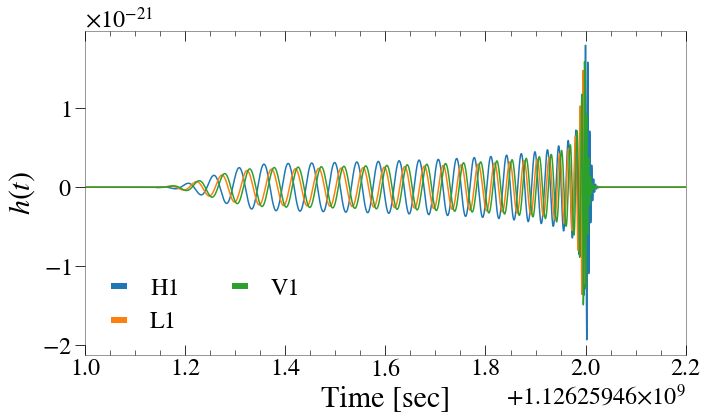

In [10]:
def PlotInjectedWaveforms(ell, SNR):
    """ Produce a plot of injected waveforms read from frames files for a given value of ell and SNR"""

    fig, ax = plt.subplots(figsize=(10, 6))

    base = root_dir + 'BilbyBayeswaveAnalysis/'

    ## Get injected paramters
    p = base + 'dCS_' + ell + '_' + str(SNR)
    params = GetInjectedParameters(p)
    print(params)
    
    for det in ["H1", "L1", "V1"]:
        strain = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
        time = np.array(strain.times)
        plt.plot(time, strain, '-', lw=1.5, label = det)

    t_gps = 1126259462.0
    plt.xlim(t_gps - 1.0, t_gps + 0.2)
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$')
    legend = plt.legend(fontsize=24, loc = 'lower left', ncol=2, frameon=False)
    plt.grid()
    plt.tight_layout()
    plt.show()
    
PlotInjectedWaveforms("0p4", 100)